In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from utils.loader import DataLoader
import matplotlib.pyplot as plt
import os

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Disable gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
batch_size = 256

In [5]:
loader = DataLoader()
img_ds = loader.get_image_ds().batch(batch_size, drop_remainder=True, num_parallel_calls=batch_size)
masks_ds = loader.get_mask_ds().batch(batch_size, drop_remainder=True, num_parallel_calls=batch_size)
label_ds = loader.get_binary_ds().batch(batch_size, drop_remainder=True, num_parallel_calls=batch_size)
bbox_ds = loader.get_bboxes_ds().batch(batch_size, drop_remainder=True, num_parallel_calls=batch_size)

In [7]:
img_height, img_width, channels = list(img_ds.take(1))[0].shape[-3:]

Plot some examples (Ignore if training)

In [28]:
# Make some examples
examples = tf.data.Dataset.zip((img_ds, masks_ds, bbox_ds)).as_numpy_iterator()
display_list = next(examples)

In [7]:
def fix_bbox(bbox):
    temp = np.zeros_like(bbox)
    temp[0], temp[1] = bbox[1], bbox[0]
    temp[2], temp[3] = bbox[3], bbox[2]
    return temp

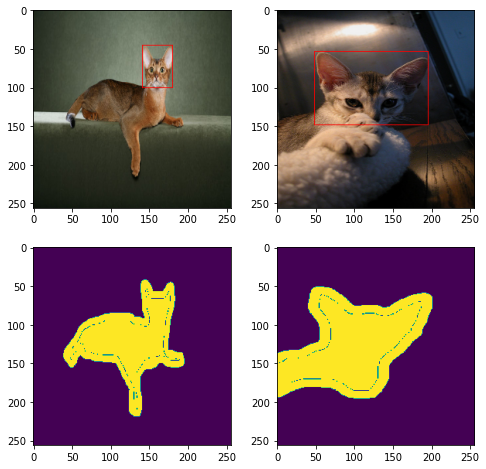

In [8]:
# View some examples -> fix bounding boxes
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    box_img = tf.image.draw_bounding_boxes(tf.expand_dims(display_list[0][i,...], 0), fix_bbox(display_list[2][i]).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    ax1[i].imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax2[i].imshow((display_list[1][i,...]))

Build our MTL

In [8]:
img_height, img_width = 256, 256

In [9]:
# Build base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, input_shape=[img_height, img_width, 3], weights='imagenet'
)

In [10]:
# Picked each final decoding layer in the EffNet architecture
layer_names = [
    'block2a_expand_activation',
    'block3a_expand_activation',
    'block4a_expand_activation',
    'block6a_expand_activation',
    'block7a_project_conv'
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name='Encoder')

encoder.trainable = False

In [7]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0]']    

In [11]:
def upsample_block(filters, size):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.ReLU())

  return result

In [12]:
# Build the up-sampler
inputs = tf.keras.layers.Input(shape=[img_height, img_width, 3])

# Downsampling through the model
skips = encoder(inputs)
x = skips[-1]
inter = skips[-1] # Save for output to binary classifier
skips = reversed(skips[:-1])

up_stack = [
    upsample_block(512, 3),
    upsample_block(256, 3),
    upsample_block(128, 3),
    upsample_block(64, 3), 
]

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

# Our multiple outputs
seg_out = tf.keras.layers.Conv2DTranspose(
    filters=3, kernel_size=3, strides=2,
    padding='same', name='segnet_out')(x)
bin_class_out = tf.keras.layers.GlobalAveragePooling2D(name='bin_class_pooling')(inter)
bin_class_out = keras.layers.Dense(2, activation='softmax', name='bin_class_out')(bin_class_out)

model = tf.keras.Model(inputs=inputs, outputs=[seg_out, bin_class_out])


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder (Functional)           [(None, 128, 128, 9  3633571     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 240                                           

Test out model

In [12]:
# take an example
a = list(img_ds.shuffle(100).take(1))[0]

In [13]:
seg_pred, bin_pred = model.predict(display_list[0][tf.newaxis,...])

NameError: name 'display_list' is not defined

In [ ]:
bin_pred

array([[0.25048855, 0.7495115 ]], dtype=float32)

In [ ]:
seg_max = tf.argmax(seg_pred, axis=-1)
seg_max = seg_max[..., tf.newaxis][0]

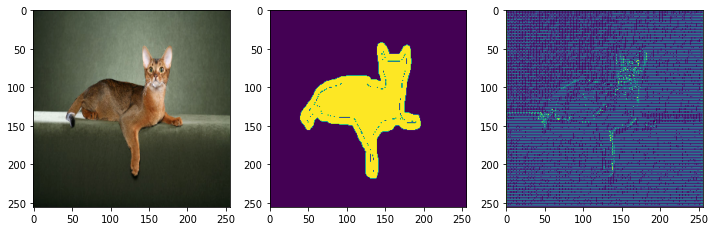

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
ax1.imshow(tf.keras.utils.array_to_img(tf.squeeze(display_list[0])))
ax2.imshow((display_list[1]))
ax3.imshow(seg_max)

Train model

In [10]:
# Can use this but use generator img fcn instead
train_ds = tf.data.Dataset.zip(((img_ds), (masks_ds, label_ds)))

In [13]:
#keras.optimizers.Adam(4.3e-5) Errors here?
model.compile(optimizer=keras.optimizers.Adam(4.3e-5),
              loss={'segnet_out' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              metrics=['accuracy'])

In [14]:
def generator_img():
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        
        yield X, [Y1, Y2]

In [8]:
a = generator_img()

In [15]:
model.fit(generator_img(),epochs=10, steps_per_epoch=2000//16)